## Excercise 1: from pandas to dask DataFrame

In [66]:
# !pip install dask

In [67]:
from dask.distributed import Client

client = Client(n_workers=4)
client

C:\Users\Mahdiye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60775 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:60775/status,
Dashboard: http://127.0.0.1:60775/status,Workers: 4
Total threads: 4,Total memory: 7.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60778,Workers: 4
Dashboard: http://127.0.0.1:60775/status,Total threads: 4
Started: Just now,Total memory: 7.90 GiB
Comm: tcp://127.0.0.1:60808,Total threads: 1
Dashboard: http://127.0.0.1:60809/status,Memory: 1.98 GiB
Nanny: tcp://127.0.0.1:60781,


In [68]:
import dask.dataframe as dd
import os

In [69]:
# ddf = dd.read_csv('data/nycflights/1991.csv')

In [70]:
# Specify the glob pattern for the JSON files
file_pattern = 'data/nycflights/*.csv'

# Read the JSON files into a Dask DataFrame
ddf = dd.read_csv(file_pattern)

In [71]:
len(ddf)

2611892

In [72]:
ddf.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 23 entries, Year to Diverted
dtypes: object(3), float64(10), int64(10)

In [73]:
ddf.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [74]:
ddf.TailNum.head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: TailNum, dtype: float64

In [75]:
ddff = dd.read_csv(
    os.path.join("data", "nycflights", "*.csv"),
    parse_dates={"Date": [0, 1, 2]},
    dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool},
)

In [76]:
ddff.tail()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


In [77]:
ddff.Cancelled.head()

0    False
1    False
2    False
3    False
4    False
Name: Cancelled, dtype: bool

In [78]:
client.shutdown()

## Exercise 2: Dask_ML
### step 1: use dask as a backend

In [79]:
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

X, y = make_classification(n_samples=1000, random_state=0)
param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
                           param_grid=param_grid,
                           return_train_score=False,
                           cv=3,
                           n_jobs=-1) #n_jobs: indicate that we want to utilize all available cores for parallel processing.

grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=SVC(gamma='auto', probability=True, random_state=0),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                         'kernel': ['rbf', 'poly', 'sigmoid'],
                         'shrinking': [True, False]})

In [80]:
import joblib
import pandas as pd

with joblib.parallel_backend('dask'):
    grid_search.fit(X, y)
    
# Convert the results to a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

In [81]:
# results_df

In [82]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'C': 1.0, 'kernel': 'rbf', 'shrinking': True}
Best Score: 0.9489969010927095


### step 2: classify with dask_ml

In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from dask_ml.linear_model import LogisticRegression as DaskLogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [84]:
df = pd.read_csv("../data/moons-data.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../data/moons-data.csv'

In [ ]:
import numpy as np

X = df.iloc[:, :2].values
y = df.iloc[:, 2].values

In [85]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, random_state=0, shuffle=True)

X_train, X_test = X[:100], X[100:]
y_train, y_test = y[:100], y[100:]

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [86]:
# modelling by LogisticRegression
from sklearn.linear_model import LogisticRegression

sklearn_model = LogisticRegression()
sklearn_model.fit(X_train, y_train)

LogisticRegression()

In [4]:
# pip install dask-ml

In [87]:
# modelling by dask-ml
import dask_ml.linear_model as dml

dask_model = dml.LogisticRegression()
dask_model.fit(X_train, y_train)

LogisticRegression()

In [24]:
# Check accuracy of both modelling method
sklearn_accuracy = sklearn_model.score(X_test, y_test)
dask_accuracy = dask_model.score(X_test, y_test)

print("Accuracy (scikit-learn):", sklearn_accuracy)
print("Accuracy (dask_ml):", dask_accuracy)

Accuracy (scikit-learn): 0.887
Accuracy (dask_ml): 0.891


In [88]:
# Train a logistic regressor from scikit-learn
sklearn_regressor = LogisticRegression()
sklearn_regressor.fit(X_train, y_train)

# Train a logistic regressor from dask-ml
dask_regressor = DaskLogisticRegression()
dask_regressor.fit(X_train, y_train)

# Predict the classes for the test data
y_pred_sklearn = sklearn_regressor.predict(X_test)
y_pred_dask = dask_regressor.predict(X_test)

# Calculate the accuracy of the models
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)
accuracy_dask = accuracy_score(y_test, y_pred_dask)

print("Accuracy (Scikit-Learn):", accuracy_sklearn)
print("Accuracy (Dask-ML):", accuracy_dask)

Accuracy (Scikit-Learn): 0.88
Accuracy (Dask-ML): 0.89


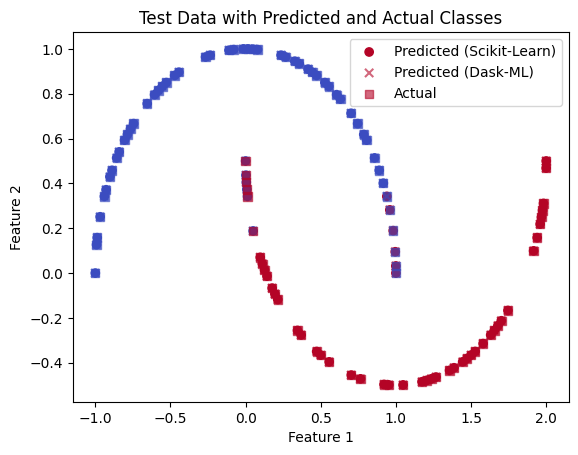

In [89]:
# Plot the test data with predicted classes
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_sklearn, cmap='coolwarm', label='Predicted (Scikit-Learn)')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_dask, cmap='coolwarm', alpha=0.6, marker='x', label='Predicted (Dask-ML)')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', alpha=0.6, marker='s', label='Actual')
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Test Data with Predicted and Actual Classes')
plt.show()

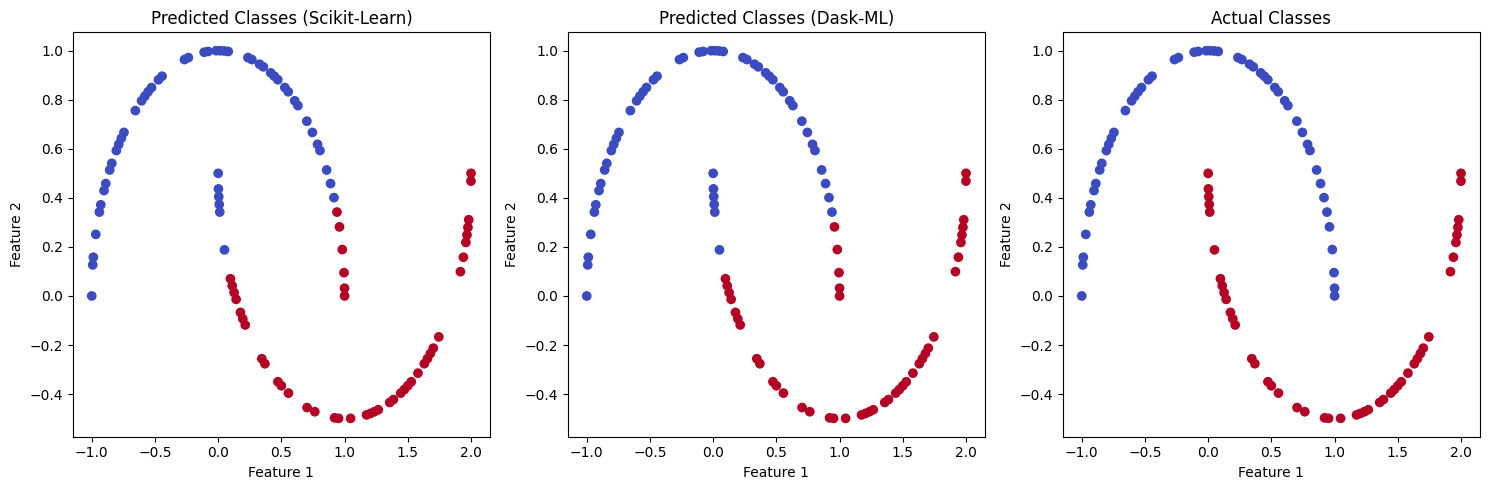

In [90]:
# Plot separately

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the test data with predicted classes (Scikit-Learn)
axes[0].scatter(X_test[:, 0], X_test[:, 1], c=y_pred_sklearn, cmap='coolwarm')
axes[0].set_title('Predicted Classes (Scikit-Learn)')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Plot the test data with predicted classes (Dask-ML)
axes[1].scatter(X_test[:, 0], X_test[:, 1], c=y_pred_dask, cmap='coolwarm')
axes[1].set_title('Predicted Classes (Dask-ML)')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

# Plot the test data with actual classes
axes[2].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm')
axes[2].set_title('Actual Classes')
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()